In [6]:
import xarray as xr
# import numpy as np
import seaborn as sns

from functools import partial
import matplotlib.pyplot as plt
import glob
import scipy.signal as signal
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib
import datetime
import cftime

In [2]:
def detrend_data(data):

    results = data.polyfit(dim='time', deg=1)
    trend = xr.polyval(data.time, results.polyfit_coefficients)
    
    # subtract trendline from data 
    new_data = data-trend 

    slope = (trend[-1] - trend[0])/len(trend)
    
    return new_data, trend

def haleys_detrend(data, deg):
#     data = Arctic_SIT_eff
    # Grouping months 
    # month2 = data.groupby('time.month')[month]
    data = data.groupby('time.month') - data.groupby('time.month').mean(dim='time')
    # Finding polyfit of that month
    polyfit = data.polyfit(dim='time', deg=1) #, skipna=True)
    # Polyval 
    trend = xr.polyval(data.time, polyfit.polyfit_coefficients)
    # subtract trendline from data 
    anoms = data-trend 

    slope = (trend[-1] - trend[0])/len(trend)
    return anoms, trend, slope


def get_monthly_anomalies(new_data):

    #new_data = detrend_data(data)

    climat = new_data.groupby('time.month').mean(dim='time')
    anoms = new_data.groupby('time.month') - climat

    return anoms

def convert_coords(lat, lon, og_data, ccrs_grid):
    """ convert data to appropriate coordinates for ccrs plot """
    
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

def fashion_space(ax):
    """ set standard design paramaters for hemispheric stereo plots """
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)

In [3]:
def markov_2(deseasonalized, lag, delt):

    null, A = lag_linregress_3D(deseasonalized, deseasonalized, lagx=0, lagy=lag-1)
    autocorrelation = A

    h_prime = deseasonalized[1:, :, :]
    h_prime_nm1 = deseasonalized[0:-1, :, :]

    r = -1 * np.log(autocorrelation)

    external = (h_prime - (1 - r*delt)*h_prime_nm1)/delt

    return h_prime, autocorrelation, r, external

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """ Input: Two xr.Datarrays of any dimensions with the first dim being time. 
        Thus the input data could be a 1D time series, or for example, have three 
        dimensions (time,lat,lon). 
        Datasets can be provided in any order, but note that the regression slope 
        and intercept will be calculated for y with respect to x.
        Output: Covariance, correlation, regression slope and intercept, p-value, 
        and standard error on regression between the two datasets along their 
        aligned time dimension.  
        Lag values can be assigned to either of the data, with lagx shifting x, and
        lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        # x   = x.shift(time = -lagx) #.dropna(dim='time')
        x   = x.shift(time = -lagx) #.dropna(dim='time')
    
        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        # y   = y.shift(time = -lagy)#.dropna(dim='time')
        y   = y.shift(time = -lagy) #.dropna(dim='time')
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor = cov/(xstd*ystd)

    return cov, cor

## PIOMAS

In [128]:
piomas_files = sorted(glob.glob('/glade/scratch/mollyw/external_data/PIOMAS/monthly/piomas_bin_reader/output/*.nc'))

In [129]:
piomas = xr.open_mfdataset(piomas_files, combine='nested', concat_dim='year') 

In [130]:
piomas_string = piomas.stack(time = ('year','t'))

In [170]:
time = []
for year in range(1979, 2022):
    for month in range(1,13):
        time.append(datetime.datetime(year,month,15))

In [172]:
piomas_string["time"] = time

In [176]:
piomas_string = piomas_string.drop('month')

In [177]:
anomalies = get_monthly_anomalies(piomas_string.thickness[:,:,-10*12+1:-12].transpose('time','x','y'))
anomalies.load()

<xarray.DataArray 'thickness' (time: 107, x: 120, y: 360)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    longitude  (x, y) float64 319.5 320.5 321.5 322.5 ... 317.9 318.4 318.8
    latitude   (x, y) float64 48.99 48.99 48.99 48.99 ... 72.71 72.71 72.71
  * time       (time) datetime64[ns] 2012-02-15 2012-03-15 ... 2020-12-15
    month      (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: x, y

In [178]:
inter = 12
nyquist = 1/2
nints = inter*10
cutoff = 1/nints*1/nyquist
decadal_sos = signal.butter(4, cutoff, 'lp', output='sos')
ann2dec_sos = signal.butter(4, [1/(inter*10) * 2, 1/(inter*1.5) * 2], 'bp', output='sos')
annual_sos = signal.butter(4, [1/(inter*1.5) * 2, 1/(inter*0.5) * 2], 'bp', output='sos')
s2s_sos = signal.butter(4, 1/(inter*0.5) * 2, 'hp', output='sos')

In [179]:
decadal_filtered = xr.apply_ufunc(partial(signal.sosfilt, decadal_sos),
                                  anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[anomalies.dtype],
                                  kwargs={'axis': 0})

In [180]:
ann2dec_filtered = xr.apply_ufunc(partial(signal.sosfilt, ann2dec_sos),
                                  anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[anomalies.dtype],
                                  kwargs={'axis': 0})

In [181]:
annual_filtered = xr.apply_ufunc(partial(signal.sosfilt, annual_sos),
                                 anomalies,
                                 # dask='parallelized',
                                 output_dtypes=[anomalies.dtype],
                                 kwargs={'axis': 0})

In [182]:
s2s_filtered = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              anomalies,
                              # dask='parallelized',
                              output_dtypes=[anomalies.dtype],
                              kwargs={'axis': 0})

In [101]:
s2s_filtered

<xarray.DataArray 'thickness' (time: 516, x: 120, y: 360)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    longitude  (x, y) float64 319.5 320.5 321.5 322.5 ... 317.9 318.4 318.8
    latitude   (x, y) float64 48.99 48.99 48.99 48.99 ... 72.71 72.71 72.71
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) MultiIndex
  - year       (time) int64 0 0 0 0 0 0 0 0 0 0 ... 42 42 42 42 42 42 42 42 42
  - t          (time) int64 0 1 2 3 4 5 6 7 8 9 10 ... 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: x, y

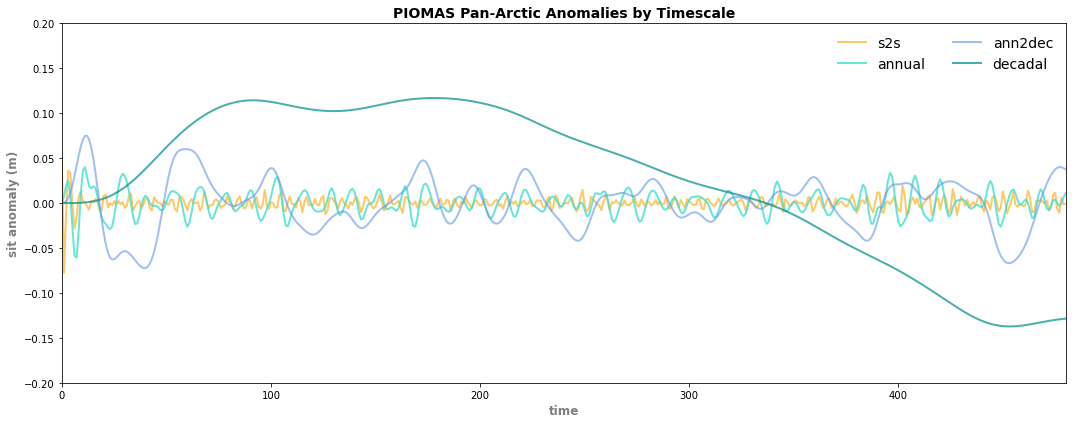

In [105]:
plt.figure(figsize=(15,6))
plt.plot(s2s_filtered.mean(dim=['x','y']), c='orange', alpha=0.6, linewidth=2)
plt.plot(annual_filtered.mean(dim=['x','y']), c='turquoise', alpha=0.8,linewidth=2)
plt.plot(ann2dec_filtered.mean(dim=['x','y']), c='cornflowerblue', alpha=0.6,linewidth=2)
plt.plot(decadal_filtered.mean(dim=['x','y']), c='darkcyan', alpha=0.7,linewidth=2)
plt.xlim([0,40*12])
plt.ylim([-0.2, 0.2])
plt.ylabel('sit anomaly (m)', fontsize=12, fontweight='bold', color='grey')
plt.xlabel('time', fontsize=12, fontweight='bold', color='grey')
plt.legend(['s2s','annual','ann2dec','decadal'], fontsize=14, ncol=2, frameon=False)
plt.title('PIOMAS Pan-Arctic Anomalies by Timescale', fontweight='bold', fontsize=14)
plt.tight_layout()

In [123]:
s2s_freq, s2s_PSD = signal.welch(s2s_filtered.mean(dim=['x','y']),
                                 fs=1,
                                 window='hann',
                                 nperseg=128,
                                 detrend=False,
                                 axis=0
                                 )

ann_freq, ann_PSD = signal.welch(annual_filtered.mean(dim=['x', 'y']),
                                 fs=1,
                                 window='hann',
                                 nperseg=128,
                                 detrend=False,
                                 axis=0
                                 )

a2d_freq, a2d_PSD = signal.welch(ann2dec_filtered.mean(dim=['x', 'y']),
                                 fs=1,
                                 window='hann',
                                 nperseg=128,
                                 detrend=False,
                                 axis=0
                                 )

dec_freq, dec_PSD = signal.welch(decadal_filtered.mean(dim=['x', 'y']),
                                 fs=1,
                                 window='hann',
                                 nperseg=128,
                                 detrend='linear',
                                 axis=0
                                 )

In [125]:
import scipy.signal as signal
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launche

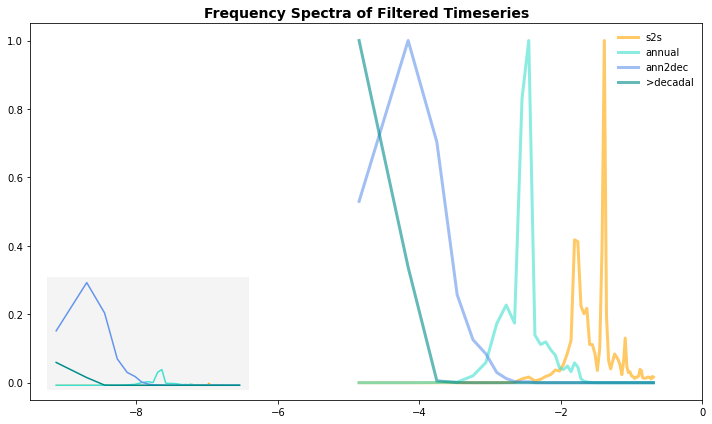

In [126]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(np.log(s2s_freq),
         s2s_PSD/max(s2s_PSD),
         color='orange',
         linewidth=3,
         alpha=0.6,
         label='s2s')

ax1.plot(np.log(ann_freq),
         ann_PSD/max(ann_PSD),
         color='turquoise',
         linewidth=3,
         alpha=0.6,
         label='annual',)

ax1.plot(np.log(a2d_freq),
         a2d_PSD/max(a2d_PSD),
         color='cornflowerblue',
         linewidth=3,
         alpha=0.6,
         label='ann2dec')

ax1.plot(np.log(dec_freq),
         dec_PSD/max(dec_PSD),
         color='darkcyan',
         linewidth=3,
         alpha=0.6,
         label='>decadal')

ax1.set_xlim([-9.5, 0])

ax1.legend(frameon=False)

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.025,0.025,0.3,0.3])
ax2.set_axes_locator(ip)
ax2.plot(np.log(s2s_freq),
         s2s_PSD,
         color='orange',
         linewidth=1)
ax2.plot(np.log(ann_freq),
         ann_PSD,
         color='turquoise',
         linewidth=1.5
         )
ax2.plot(np.log(a2d_freq),
         a2d_PSD,
         color='cornflowerblue',
         linewidth=1.5
         )
ax2.plot(np.log(dec_freq),
         dec_PSD,
         color='darkcyan',
         linewidth=1.5
         )

ax2.patch.set_facecolor('gainsboro')
ax2.patch.set_alpha(0.3)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])

# for spine in ax2.spines.values():
#     spine.set_edgecolor('grey')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax1.set_title('Frequency Spectra of Filtered Timeseries', fontweight='bold', fontsize=14)
plt.tight_layout()

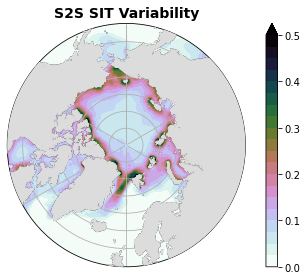

In [106]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(s2s_filtered.latitude, s2s_filtered.longitude, s2s_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('S2S SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

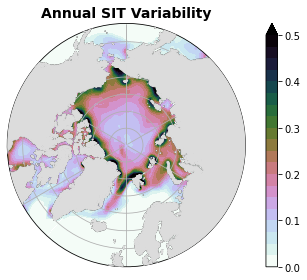

In [107]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(annual_filtered.latitude, annual_filtered.longitude, annual_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('Annual SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

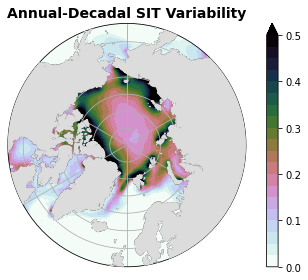

In [108]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(ann2dec_filtered.latitude, ann2dec_filtered.longitude, ann2dec_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('Annual-Decadal SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

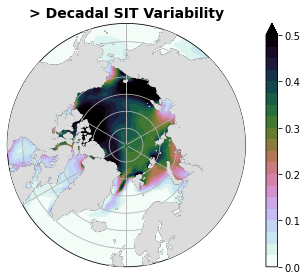

In [109]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(decadal_filtered.latitude, decadal_filtered.longitude, decadal_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('> Decadal SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

In [183]:
data_list = [decadal_filtered, ann2dec_filtered, annual_filtered, s2s_filtered]

In [184]:
names = ['decadal','ann2dec','annual','s2s']

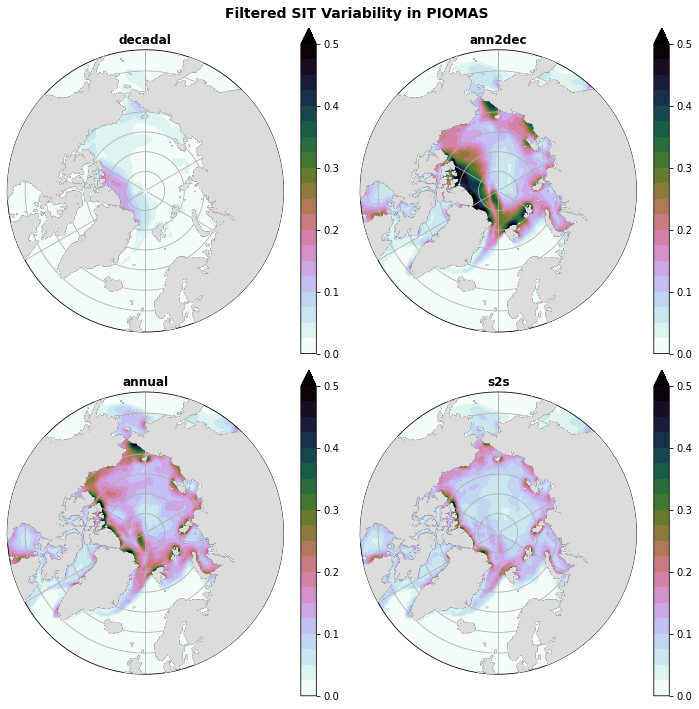

In [185]:
count = 0
count1 = 0
count2 = 0

fig, axes = plt.subplots(nrows=2, ncols=2,
                         figsize=(10, 10),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,4): 
    
    ax = axes[count1][count2]
    fashion_space(ax)

    xs, ys, data_to_plot = convert_coords(data_list[i].latitude, data_list[i].longitude, data_list[i].std(dim='time'), ccrs.NorthPolarStereo())
    cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(0, 0.5, 6)
    clevs = np.linspace(0, 0.5, 21)
    img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
    ax.set_title(names[i], fontweight='bold', fontsize=12)

    count += 1
    count2 += 1
    if count2 > 1:
        count2 = 0
        count1 += 1

plt.suptitle('Filtered SIT Variability in PIOMAS', fontweight='bold', fontsize=14)
plt.tight_layout()

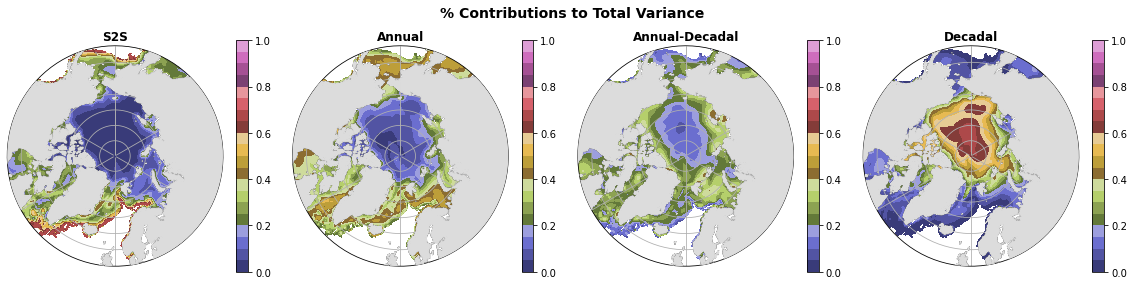

In [110]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), subplot_kw={'projection': ccrs.NorthPolarStereo()})
nps = ccrs.NorthPolarStereo()

ratio_s2s = s2s_filtered.var(dim='time')/anomalies.var(dim='time')
ratio_ann = annual_filtered.var(dim='time')/anomalies.var(dim='time')
ratio_a2d = ann2dec_filtered.var(dim='time')/anomalies.var(dim='time')
ratio_dec = decadal_filtered.var(dim='time')/anomalies.var(dim='time')

ratios = {'s2s':ratio_s2s, 'ann':ratio_ann, 'a2d':ratio_a2d, 'dec':ratio_dec}
tags = ['s2s','ann','a2d','dec']
titles = ['S2S', 'Annual', 'Annual-Decadal', 'Decadal']

for i in range(0, 4):
    fashion_space(axes[i])
    xs, ys, data_to_plot = convert_coords(s2s_filtered.latitude, s2s_filtered.longitude, ratios[tags[i]], ccrs.NorthPolarStereo())
    cmap = plt.cm.tab20b
    clevs_label = np.linspace(0, 1, 6)
    clevs = np.linspace(0, 1, 21)
    img = axes[i].contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap)
    cbar2 = fig.colorbar(img, ax=axes[i], ticks= clevs_label)
    axes[i].set_title(titles[i], fontweight='bold', fontsize=12)

plt.suptitle('% Contributions to Total Variance', fontsize=14, fontweight='bold')
plt.tight_layout()

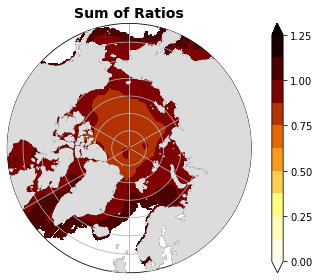

In [121]:
sum_ratios = ratio_s2s + ratio_ann + ratio_a2d + ratio_dec

fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(decadal_filtered.latitude, decadal_filtered.longitude, sum_ratios, ccrs.NorthPolarStereo())
cmap = plt.cm.afmhot_r
clevs_label = np.linspace(0, 1.25, 6)
clevs = np.linspace(0, 1.25, 11)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend='both')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('Sum of Ratios', fontweight='bold', fontsize=14)
plt.tight_layout()

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


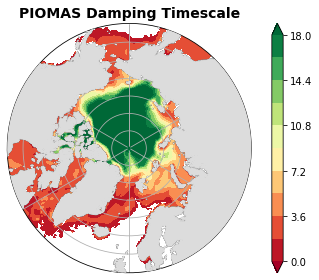

In [116]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)

h_prime, auto, damp, external = markov_2(anomalies, 2, 1)
fashion_space(ax)

upper = 18
xs, ys, data_to_plot = convert_coords(damp.latitude, 
                                      damp.longitude, 
                                      1/damp, ccrs.NorthPolarStereo())
cmap = plt.cm.RdYlGn
clevs_label = np.linspace(0, upper, 6)
clevs = np.linspace(0, upper, 11)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend='both')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('PIOMAS Damping Timescale', fontweight='bold', fontsize=14)
plt.tight_layout()

## CryoSat-2 (Bristol Product)

In [58]:
cs2_files = '/glade/scratch/mollyw/external_data/CryoSat-2/YR_Cryosat-2/ubristol_cryosat2_seaicethickness_nh_80km_v1p7.nc'
cs2_data = xr.open_dataset(cs2_files, decode_times=False)

In [59]:
cs2_data = cs2_data.rename({'t':'time'})

In [51]:
no_days_0001 = cs2_data.Time - 366

In [53]:
time=[]
for srl_no in no_days_0001.values:
    time.append(datetime.datetime(1,1,1,0,0) + datetime.timedelta(srl_no-1))

In [61]:
cs2_data["time"] = time

In [64]:
cs2_data = cs2_data.drop("Time")

In [110]:
data = []
for year in range(2011, 2020):
    for month in range(1,13):
        data.append(cs2_data.groupby('time.year')[year].groupby('time.month')[month].mean(dim='time'))

data = xr.concat(data, dim='time')

In [114]:
time = []
for year in range(2011,2020):
    for month in range(1,13):
        time.append(datetime.datetime(year,month, 15))

In [115]:
data["time"] = time

In [117]:
data

<xarray.Dataset>
Dimensions:                        (time: 108, x: 100, y: 100)
Coordinates:
  * time                           (time) datetime64[ns] 2011-01-15 ... 2019-...
Dimensions without coordinates: x, y
Data variables:
    Mode                           (time) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Latitude                       (time, y, x) float64 41.34 41.77 ... 41.34
    Longitude                      (time, y, x) float64 -45.0 -45.58 ... 135.0
    Sea_Ice_Thickness              (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
    Sea_Ice_Thickness_Uncertainty  (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
    Sea_Ice_Concentration          (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
    Sea_Ice_Type                   (time, y, x) float64 nan nan nan ... nan nan

In [118]:
anomalies = get_monthly_anomalies(data.Sea_Ice_Thickness)
anomalies.load()

<xarray.DataArray 'Sea_Ice_Thickness' (time: 108, y: 100, x: 100)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2011-01-15 2011-02-15 ... 2019-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x

In [83]:
anomalies = anomalies[6:-14]

In [119]:
inter = 12
nyquist = 1/2
nints = inter*10
cutoff = 1/nints*1/nyquist
decadal_sos = signal.butter(4, cutoff, 'lp', output='sos')
ann2dec_sos = signal.butter(4, [1/(inter*10) * 2, 1/(inter*1.5) * 2], 'bp', output='sos')
annual_sos = signal.butter(4, [1/(inter*1.5) * 2, 1/(inter*0.5) * 2], 'bp', output='sos')
s2s_sos = signal.butter(4, 1/(inter*0.5) * 2, 'hp', output='sos')

In [120]:
decadal_filtered = xr.apply_ufunc(partial(signal.sosfilt, decadal_sos),
                                  anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[anomalies.dtype],
                                  kwargs={'axis': 0})

In [121]:
ann2dec_filtered = xr.apply_ufunc(partial(signal.sosfilt, ann2dec_sos),
                                  anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[anomalies.dtype],
                                  kwargs={'axis': 0})

In [122]:
annual_filtered = xr.apply_ufunc(partial(signal.sosfilt, annual_sos),
                                 anomalies,
                                 # dask='parallelized',
                                 output_dtypes=[anomalies.dtype],
                                 kwargs={'axis': 0})

In [123]:
s2s_filtered = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              anomalies,
                              # dask='parallelized',
                              output_dtypes=[anomalies.dtype],
                              kwargs={'axis': 0})

In [124]:
data_list = [decadal_filtered, ann2dec_filtered, annual_filtered, s2s_filtered]

In [125]:
names = ['decadal','ann2dec','annual','s2s']

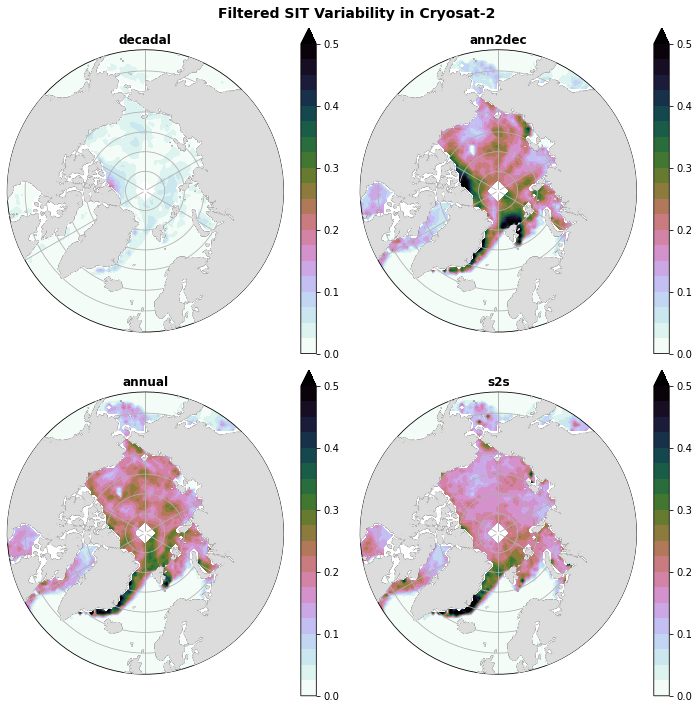

In [127]:
count = 0
count1 = 0
count2 = 0

fig, axes = plt.subplots(nrows=2, ncols=2,
                         figsize=(10, 10),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})
for i in range(0,4): 
    
    ax = axes[count1][count2]
    fashion_space(ax)

    xs, ys, data_to_plot = convert_coords(cs2_data.Latitude, cs2_data.Longitude, data_list[i].std(dim='time'), ccrs.NorthPolarStereo())
    cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(0, 0.5, 6)
    clevs = np.linspace(0, 0.5, 21)
    img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
    ax.set_title(names[i], fontweight='bold', fontsize=12)

    count += 1
    count2 += 1
    if count2 > 1:
        count2 = 0
        count1 += 1

plt.suptitle('Filtered SIT Variability in Cryosat-2', fontweight='bold', fontsize=14)
plt.tight_layout()

## SCRATCH

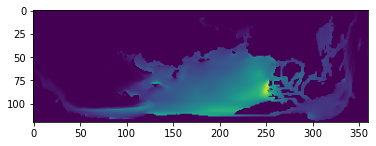

In [46]:
plt.imshow(mean_year.thickness[12,:,:])

In [17]:
timeseries = piomas.mean(dim=['x','y'])
timeseries = timeseries.to_dataframe()

In [23]:
timeseries

thickness  month
t  year                  
0  0      0.789762      1
   1      0.736296      1
   2      0.722059      1
   3      0.637387      1
   4      0.692360      1
...            ...    ...
11 38     0.365559     12
   39     0.384028     12
   40     0.360525     12
   41     0.352402     12
   42     0.377090     12

[516 rows x 2 columns]

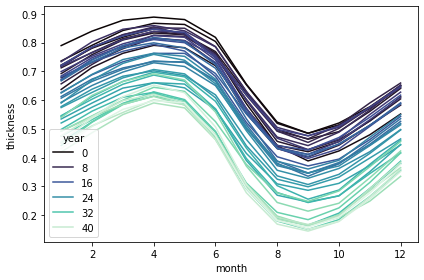

In [28]:
sns.lineplot(data=timeseries, x ='month', y = 'thickness', hue='year', palette='mako')
plt.tight_layout()

In [2]:
piomas_files = sorted(glob.glob('/glade/scratch/mollyw/external_data/PIOMAS/conc/monthly/piomas_bin_reader/output/*.nc'))
piomas = xr.open_mfdataset(piomas_files, combine='nested', concat_dim='year') 
piomas_area = piomas.area.stack(time = ('year','t'))

In [3]:
piomas_files = sorted(glob.glob('/glade/scratch/mollyw/external_data/PIOMAS/monthly/piomas_bin_reader/output/*.nc'))
piomas = xr.open_mfdataset(piomas_files, combine='nested', concat_dim='year') 
piomas_volume = piomas.thickness.stack(time = ('year','t'))

In [4]:
mean_thickness = piomas_volume.sum(dim=['x','y'])/piomas_area.sum(dim=['x','y'])

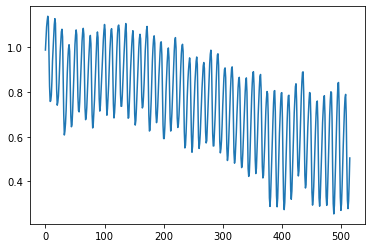

In [10]:
plt.plot(mean_thickness)

In [8]:
count = 0
months = np.arange(1,13)
years = np.arange(1979, 2022)

dates =[]
for i in years:
    for j in months:
        dates.append(datetime.datetime(i, j, 15))

In [9]:
mean_thickness['time'] = dates

In [12]:
dtnd, trend = detrend_data(mean_thickness)

In [13]:
anoms = get_monthly_anomalies(dtnd)

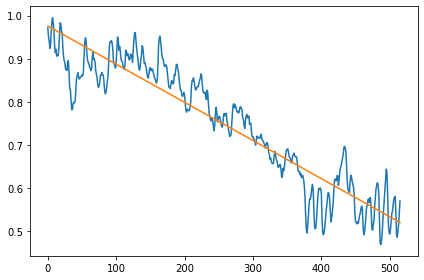

In [15]:
# plt.plot(anoms)
plt.plot(anoms+trend)
plt.plot(trend)
plt.tight_layout()